### Section I: Non-Local Spin Interactions
In this project, we study a 1D Classical Heisenberg Model with long-range (non-local) interactions.

The spins $\vec{S}_i$ are 3D unit vectors interacting via a decaying power law:
$$J_{ij}=\dfrac{J}{|x_i-x_j|^\alpha}$$
where $J$ is the overall interaction strength and $\alpha$ controls how fast the interaction decays with distance.

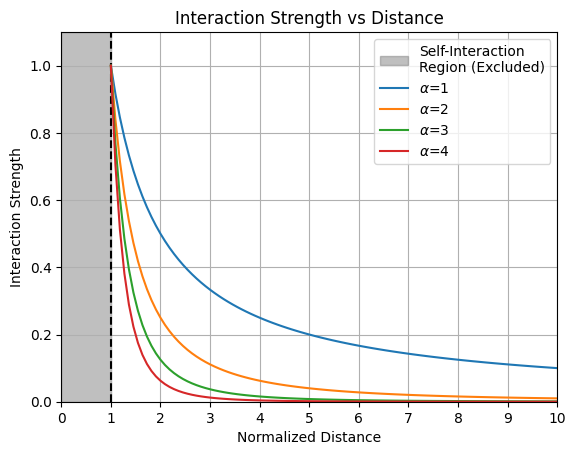

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt


# Interaction strength function
J = 1.0  # Interaction strength constant
def interaction(x1, x2, alpha):
    return J / np.abs(x1 - x2) ** alpha


# Plot a vertical line at x=1 to indicate the self-interaction region (interaction strength = 0)
plt.axvline(x=1, color='black', linestyle='--')
plt.fill_betweenx([0, J*1.1], 0, 1, color='gray', alpha=0.5, label='Self-Interaction\nRegion (Excluded)')

# Plot the interaction strength as a function of distance and alpha
normalized_distance = np.linspace(1, 10, 100)
interaction_decay = list(range(1, 5))
for alpha in interaction_decay:
    plt.plot(normalized_distance, interaction(normalized_distance, 0, alpha), label=rf'$\alpha$={alpha}')

# Set up the plot
plt.title('Interaction Strength vs Distance')
plt.xlabel('Normalized Distance')
plt.ylabel('Interaction Strength')
plt.ylim(0, J*1.1)
plt.xlim(0, 10)
plt.xticks(np.arange(0, 11, 1))
plt.legend()
plt.grid()
plt.show()

### Section II: Spin Chain Setup
Each spin $\vec{S}_i$ is a 3D unit vector:
$$\begin{align}
\vec{S}_i&\in\mathbb{R}^3 & |\vec{S}_i|=1
\end{align}$$
We initialize the spin chain randomly with unit vectors.
The interaction matrix $J_{ij}$ is computed once for a given $\alpha$.

Interaction matrix:
 [[0.         1.         0.25       0.11111111 0.0625     0.04
  0.02777778 0.02040816 0.015625   0.01234568]
 [1.         0.         1.         0.25       0.11111111 0.0625
  0.04       0.02777778 0.02040816 0.015625  ]
 [0.25       1.         0.         1.         0.25       0.11111111
  0.0625     0.04       0.02777778 0.02040816]
 [0.11111111 0.25       1.         0.         1.         0.25
  0.11111111 0.0625     0.04       0.02777778]
 [0.0625     0.11111111 0.25       1.         0.         1.
  0.25       0.11111111 0.0625     0.04      ]
 [0.04       0.0625     0.11111111 0.25       1.         0.
  1.         0.25       0.11111111 0.0625    ]
 [0.02777778 0.04       0.0625     0.11111111 0.25       1.
  0.         1.         0.25       0.11111111]
 [0.02040816 0.02777778 0.04       0.0625     0.11111111 0.25
  1.         0.         1.         0.25      ]
 [0.015625   0.02040816 0.02777778 0.04       0.0625     0.11111111
  0.25       1.         0.         1.

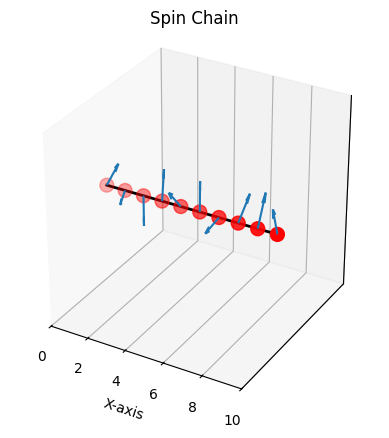

In [14]:
# Imports
import numpy as np
import matplotlib.pyplot as plt


# Generate random unit vectors
def random_unit_vector():
    vec = np.random.normal(0, 1, 3)
    return vec / np.linalg.norm(vec)

# Interaction matrix precomputation
def precompute_interaction_matrix(N, alpha):
    J_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            coupling = interaction(i, j, alpha)
            J_matrix[i, j] = coupling
            J_matrix[j, i] = coupling  # Symmetric matrix
    return J_matrix


# Parameters
N = 10     # Number of spins
alpha = 2  # Interaction dropoff exponent

# Create a list of random spins in a spin chain
position = np.array([i for i in range(N)])
spins    = np.array([random_unit_vector() for _ in range(N)])

# Precompute the interaction matrix
J_matrix = precompute_interaction_matrix(N, alpha)
print("[Test] Interaction matrix:\n", J_matrix)

# Plot the spins on a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points, spins, and spin-chain line
ax.plot(position, np.zeros(N), np.zeros(N), color='black', linewidth=2, label='Spin Chain')
ax.scatter(position, np.zeros(N), np.zeros(N), s=100, color='red', marker='o')
ax.quiver(position, np.zeros(N), np.zeros(N), spins[:, 0], spins[:, 1], spins[:, 2], length=0.25, normalize=True, label='Spin Directions')

# Set up the plot
ax.set_title('Spin Chain')
ax.set_xlabel('X-axis')
ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1
ax.set_xlim([0, N])
ax.set_ylim([-0.75, 0.75])
ax.set_zlim([-0.75, 0.75])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

### Section III: Energy Calculation
The total energy of the spin system (without an external magnetic field) is:
$$E=\sum_{i,j}J_{ij}\left(\vec{s}_i\cdot\vec{s}_j\right)$$
where $(\vec{s}_i \cdot \vec{s}_j)$ is the dot product between spins and the $1/2$ accounts for double-counting interactions.

In [15]:
# Imports
import numpy as np
import matplotlib.pyplot as plt


# Calculate the total energy of the system
def total_energy(spins, J_matrix):
    E = 0.0
    for i in range(N):
        for j in range(i+1, N):
            E -= J_matrix[i, j] * np.dot(spins[i], spins[j])
    return E


# Parameters
N = 10     # Number of spins
alpha = 2  # Interaction dropoff exponent

# Create a list of random spins in a spin chain
spins = np.array([random_unit_vector() for _ in range(N)])
J_matrix = precompute_interaction_matrix(N, alpha)

# Calculate the total energy of the system
E = total_energy(spins, J_matrix)
print("[Test] Total energy of the system:", E)

Total energy of the system: 3.0788559008431235


### Section IV: Monte Carlo Stepping
To update spins, we use the Metropolis algorithm:
1. Propose a small random rotation of a spin.
2. Calculate the energy change $\Delta E$.
3. Accept the move with probability $\min(1, e^{-\Delta E/T})$.

The random rotation is implemented using a small-angle rotation formula called the [Rodrigues' rotation formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula).

[Test] Initial energy of the system: -4.706972821848754
[Test] New energy of the system: -4.840877263766701
[Test] Change in energy: -0.13390444191794693


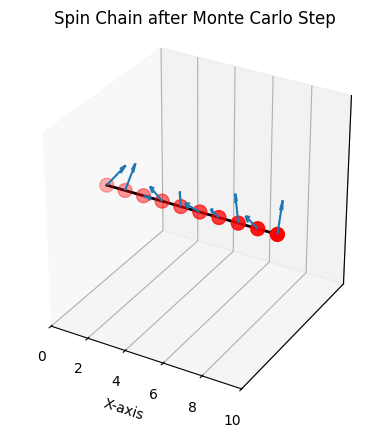

In [49]:
# Imports
import numpy as np
import matplotlib.pyplot as plt


# Rotate a spin vector by a small random angle
def random_small_rotation(vector, max_angle):

    # Generate a random axis and angle for rotation
    random_axis = random_unit_vector()
    random_angle = np.random.uniform(-max_angle, max_angle)
    random_axis = random_axis / np.linalg.norm(random_axis)

    # Rodrigues' rotation formula
    rotated_vector = (
        vector * np.cos(random_angle) +
        np.cross(random_axis, vector) * np.sin(random_angle) +
        random_axis * np.dot(random_axis, vector) * (1 - np.cos(random_angle))
    )

    # Return the rotated spin vector
    return rotated_vector / np.linalg.norm(rotated_vector)

# Perform a Monte Carlo step
def monte_carlo_step(spins, J_matrix, T):

    # Choose a random index to change the spin of
    i = np.random.randint(0, len(spins))

    # Create a new spin by rotating the old one by some random angle
    old_spin = spins[i].copy()
    new_spin = random_small_rotation(old_spin, np.pi / 4)

    # Calculate the change in energy
    dE = 0.0
    for j in range(N):
        if j != i:
            dE -= J_matrix[i, j] * (np.dot(new_spin, spins[j]) - np.dot(old_spin, spins[j]))
    if (dE < 0) or (np.random.rand() < np.exp(-dE / T)):
        spins[i] = new_spin  # Accept move
    return spins


# Parameters
N = 10     # Number of spins
alpha = 2  # Interaction dropoff exponent
TEMPERATURE = 1.0    # Temperature

# Create a list of random spins in a spin chain
spins = np.array([random_unit_vector() for _ in range(N)])
J_matrix = precompute_interaction_matrix(N, alpha)

# Calculate the total energy of the system
E = total_energy(spins, J_matrix)
print("[Test] Initial energy of the system:", E)

# Perform a Monte Carlo step
spins = monte_carlo_step(spins, J_matrix, TEMPERATURE)
E_new = total_energy(spins, J_matrix)
print("[Test] New energy of the system:", E_new)
print("[Test] Change in energy:", E_new - E)


# Function to plot the spin chain in 3D for later use
def plot_spin_chain(spins, position):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points, spins, and spin-chain line
    ax.scatter(position, np.zeros(N), np.zeros(N), s=100, color='red', marker='o')
    ax.quiver(position, np.zeros(N), np.zeros(N), spins[:, 0], spins[:, 1], spins[:, 2], length=0.25, normalize=True, label='Spin Directions')
    ax.plot(position, np.zeros(N), np.zeros(N), color='black', linewidth=2, label='Spin Chain')

    # Set up the plot
    ax.set_title('Spin Chain after Monte Carlo Step')
    ax.set_xlabel('X-axis')
    ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1
    ax.set_xlim([0, N])
    ax.set_ylim([-0.75, 0.75])
    ax.set_zlim([-0.75, 0.75])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.show()

# Plot the spin chain after the Monte Carlo step
plot_spin_chain(spins, position)

### Section V: Simulation Loop
For each $\alpha$, we simulate the system across a range of temperatures.

We measure:
 - Average energy $\langle E \rangle$
 - Average squared magnetization $\langle M^2 \rangle$

where magnetization is defined as:
$$\vec{M}=\dfrac{1}{N}\sum_i\vec{s}_i$$

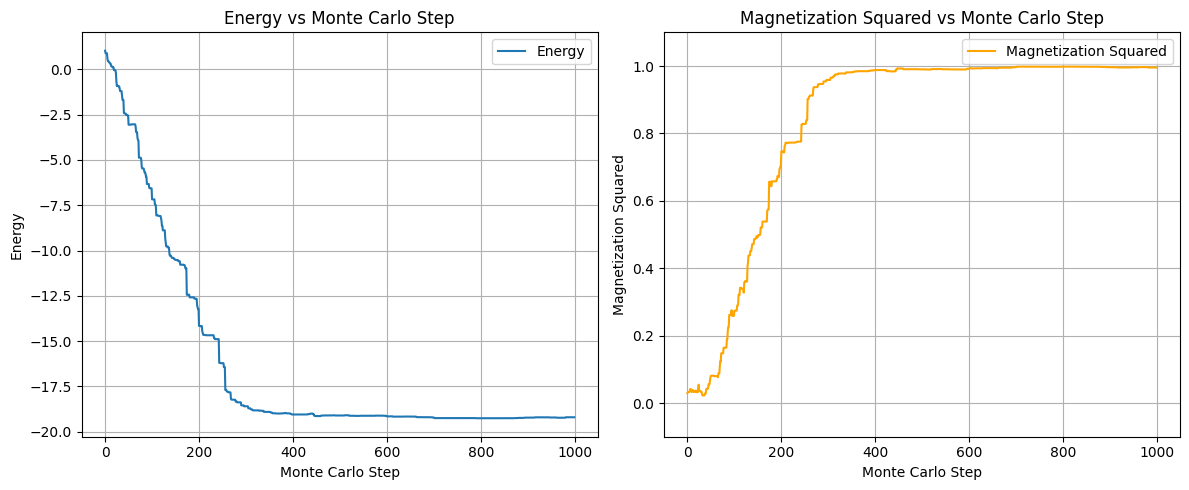

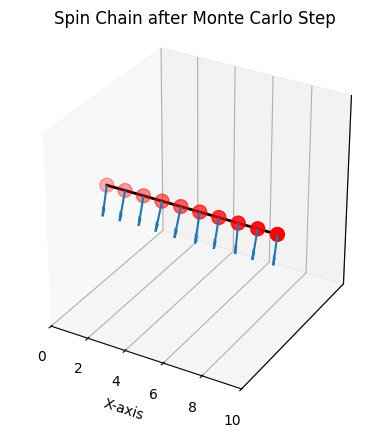

In [73]:
# Imports
import numpy as np
import matplotlib.pyplot as plt


# Runs a Monte Carlo simulation for the spin system
def simulate(alpha, total_steps=1000, T=1.0):

    spins = np.array([random_unit_vector() for _ in range(N)])
    J_matrix = precompute_interaction_matrix(N, alpha)
    
    E_list = []
    M2_list = []
    
    for step in range(total_steps):
        spins = monte_carlo_step(spins, J_matrix, T)
        E = total_energy(spins, J_matrix)
        M = np.sum(spins, axis=0) / N
        M2 = np.dot(M, M)

        
        E_list.append(E)
        M2_list.append(M2)
    
    return spins, E_list, M2_list

# Parameters
N = 10     # Number of spins
ALPHA = 1  # Interaction dropoff exponent
total_steps = 1_000  # Total number of Monte Carlo steps
TEMPERATURE = 0.01    # Temperature

# Run the simulation
spins, E_list, M2_list = simulate(ALPHA, total_steps, TEMPERATURE)

# Plot the energy and magnetization squared over time, as well as the final spin configuration
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(E_list, label='Energy')
plt.xlabel('Monte Carlo Step')
plt.ylabel('Energy')
plt.title('Energy vs Monte Carlo Step')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(M2_list, label='Magnetization Squared', color='orange')
plt.xlabel('Monte Carlo Step')
plt.ylabel('Magnetization Squared')
plt.ylim(-0.1, 1.1)
plt.title('Magnetization Squared vs Monte Carlo Step')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Plot the final spin configuration
plot_spin_chain(spins, np.array([i for i in range(N)]))

### Section VI: Known Results for 1D Long-Range Heisenberg Model

In the case of a long-range interaction of the form:

$$J_{x_1,x_2} \sim \frac{1}{|x_1 - x_2|^{\alpha}},$$

the following are known from analytical results and literature:

- The **thermodynamic limit** (i.e., $N \to \infty$) is well-defined if $\alpha > 1$.
- The **magnetization** behaves differently based on $\alpha$:
  - If $\alpha \geq 2$, the magnetization remains **zero** at any nonzero temperature.
  - If $1 < \alpha < 2$, then at **sufficiently low temperature**, the system can develop **nonzero magnetization**. These bounds are sometimes referred to as *infrared bounds*.
- For $\alpha \leq 1$, the model becomes non-extensive, and additional regularization is often required.

These predictions can be tested numerically by varying $\alpha$ and observing whether the system develops long-range magnetic order.


### Section VII: Numerical Verification of the Magnetization Threshold

From analytical results, we know:

- **Magnetization can emerge** for $1 < \alpha < 2$ at low temperatures.
- **No spontaneous magnetization** should occur for $\alpha \geq 2$.

We now verify this by running simulations for $\alpha = 1.5$, $2.0$, and $2.5$ at a low temperature $T = 0.01$.
We expect to see:

- For $\alpha = 1.5$: magnetization $\langle M^2 \rangle \to \text{nonzero}$
- For $\alpha = 2.0$ or higher: $\langle M^2 \rangle \to 0$


In [103]:
# Parameters
N = 20
TEMPERATURE = 0.01
total_steps = 10_000
alphas_to_test = np.arange(1, 5.25, 0.25)  # Range of alpha values to test

# Store results
alpha_results = {}

for alpha_val in alphas_to_test:
    print(f"Simulating α={alpha_val}")
    spins, E_list, M2_list = simulate(alpha=alpha_val, total_steps=total_steps, T=TEMPERATURE)
    alpha_results[alpha_val] = {
        'spins': spins,
        'energy': E_list,
        'magnetization_squared': M2_list
    }


Simulating α=1.0
Simulating α=1.25
Simulating α=1.5
Simulating α=1.75
Simulating α=2.0
Simulating α=2.25
Simulating α=2.5
Simulating α=2.75
Simulating α=3.0
Simulating α=3.25
Simulating α=3.5
Simulating α=3.75
Simulating α=4.0
Simulating α=4.25
Simulating α=4.5
Simulating α=4.75
Simulating α=5.0


We now plot the magnetization squared $\langle M^2 \rangle$ over Monte Carlo time for each $\alpha$ value.  
We expect convergence to a **nonzero** value for $\alpha = 1.5$, and decay to **zero** for larger $\alpha$.

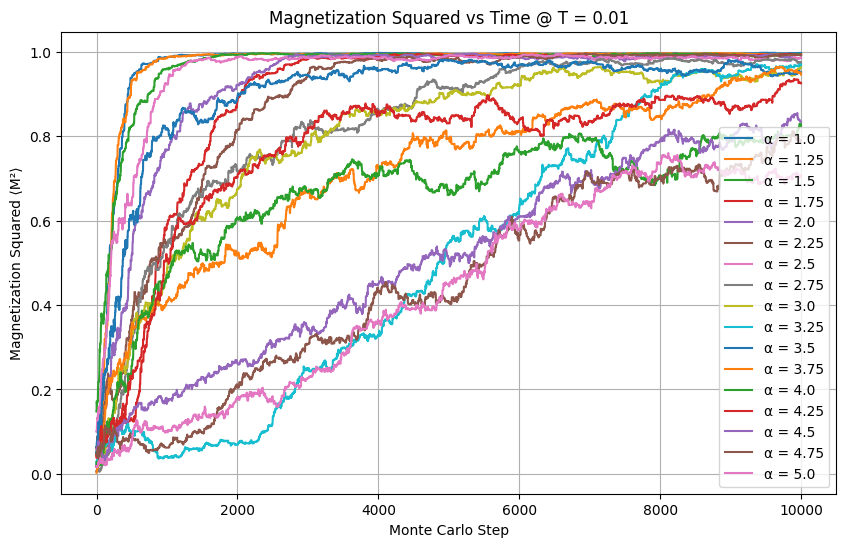

In [104]:
plt.figure(figsize=(10, 6))
for alpha_val in alphas_to_test:
    M2_list = alpha_results[alpha_val]['magnetization_squared']
    plt.plot(M2_list, label=f'α = {alpha_val}')
plt.xlabel('Monte Carlo Step')
plt.ylabel('Magnetization Squared ⟨M²⟩')
plt.title(f'Magnetization Squared vs Time @ T = {TEMPERATURE}')
plt.legend()
plt.grid()
plt.show()


#### Interpretation

- For $\alpha<2.0$, the magnetization squared stays elevated, indicating partial ordering at low temperature.
- For $\alpha\ge2.0$, $\langle M^2 \rangle$ decreases over time and stabilizes near zero, consistent with **no long-range order**.

This matches known theoretical predictions that **long-range order is only possible when $1 < \alpha < 2$**.

To better quantify steady-state behavior, we compute the average and standard deviation of $\langle M^2 \rangle$ over the last 10% of simulation steps. This tells us how ordered the system remains at low temperature for each value of $\alpha$.



In [105]:
# How many steps to average over (last 10%)
def summarize_magnetization(M2_list, fraction=0.10):
    cutoff = int(len(M2_list) * (1 - fraction))
    last_M2 = M2_list[cutoff:]
    return np.mean(last_M2), np.std(last_M2)

# Print the summary
print(f"{'Alpha':>8} | {'⟨M²⟩':>10} | {'StdDev':>10}")
print("-" * 32)
for alpha_val in alphas_to_test:
    M2_list = alpha_results[alpha_val]['magnetization_squared']
    mean, std = summarize_magnetization(M2_list)
    print(f"{alpha_val:>8.2f} | {mean:>10.4f} | {std:>10.4f}")


   Alpha |       ⟨M²⟩ |     StdDev
--------------------------------
    1.00 |     0.9971 |     0.0007
    1.25 |     0.9949 |     0.0013
    1.50 |     0.9924 |     0.0017
    1.75 |     0.9929 |     0.0012
    2.00 |     0.9903 |     0.0025
    2.25 |     0.9908 |     0.0025
    2.50 |     0.9831 |     0.0026
    2.75 |     0.9772 |     0.0053
    3.00 |     0.9445 |     0.0071
    3.25 |     0.9609 |     0.0073
    3.50 |     0.9591 |     0.0119
    3.75 |     0.9470 |     0.0106
    4.00 |     0.7962 |     0.0099
    4.25 |     0.8941 |     0.0253
    4.50 |     0.8152 |     0.0206
    4.75 |     0.7607 |     0.0283
    5.00 |     0.7052 |     0.0097


### Final Result: Magnetization vs Interaction Exponent α

We now plot the average magnetization squared $\langle M^2 \rangle$ as a function of the decay exponent $\alpha$.

This captures the transition from long-range order (for $\alpha < 2$) to disordered behavior (for $\alpha \geq 2$), consistent with theoretical predictions.

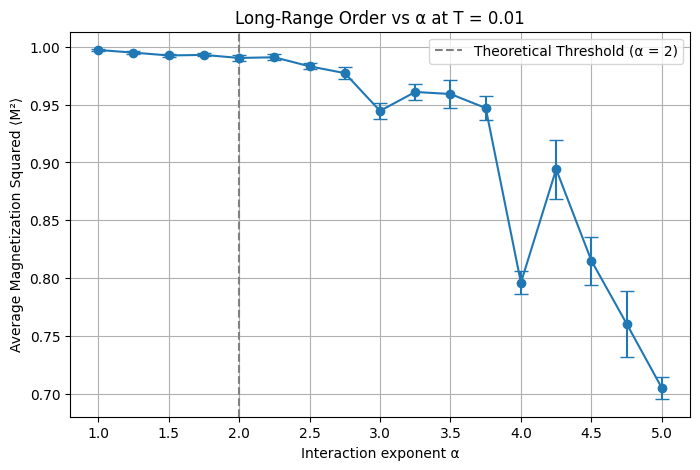

In [106]:
# Gather averaged data
alpha_vals = []
M2_means = []
M2_stds = []

for alpha_val in alphas_to_test:
    M2_list = alpha_results[alpha_val]['magnetization_squared']
    mean, std = summarize_magnetization(M2_list)
    alpha_vals.append(alpha_val)
    M2_means.append(mean)
    M2_stds.append(std)

# Plot with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(alpha_vals, M2_means, yerr=M2_stds, fmt='o-', capsize=5)
plt.axvline(2.0, linestyle='--', color='gray', label='Theoretical Threshold (α = 2)')
plt.xlabel('Interaction exponent α')
plt.ylabel('Average Magnetization Squared ⟨M²⟩')
plt.title(f'Long-Range Order vs α at T = {TEMPERATURE}')
plt.grid(True)
plt.legend()
plt.show()


### Interpretation of Results

The plot of $\langle M^2 \rangle$ versus $\alpha$ provides strong numerical evidence of a transition around $\alpha = 2$:

- For $\alpha < 2$, the system develops long-range order at low temperature, reflected by high values of $\langle M^2 \rangle$.
- As $\alpha$ approaches 2, the ordering weakens.
- For $\alpha \geq 2$, the system fails to sustain strong magnetization, in agreement with the known infrared bounds for 1D long-range interactions. It also tends to have much wider variance in the magnetization datapoints, meaning there is less of a convergence.

This supports the theoretical prediction that spontaneous magnetization is only possible at low temperature if: $1 < \alpha < 2$

Overall, our simulation captures the qualitative features of the 1D classical Heisenberg model with power-law-decaying interactions.
